##### Quantum Data Science 2023/2024
## Lecture 6 - Encoding classical data into quantum circuits

## Contents

1. [Important Functions](#important)
2. [Basis Encoding](#basis_encoding)
3. [Amplitude Encoding](#amplitude_encoding)
4. [Angle Encoding](#angle_encoding)
5. [IQP Encoding](#iqp_encoding)    

### 1. Important functions and libraries <a id="important"></a>

###### again

In [ ]:
from qiskit import *
from qiskit.primitives import Sampler,Estimator
import numpy as np

def execute_circuit(qc, shots=1024, seed=None, binary=False , primitive="sampler", observable=None, reverse=False):

    #if reverse:
    #    qc=qc.reverse_bits()
    
    if primitive == "estimator":
        options = {"shots": shots, "seed": seed}
        estimator = Estimator(options=options)
    
        job = estimator.run(qc, observable)
        result = job.result()  
        
        return result
    
    elif primitive == "sampler":
        options = {"shots": shots, "seed": seed}
        sampler = Sampler(options=options)
    
        job = sampler.run(qc)
        result = job.result()  
        
        probability_dictionary = result.quasi_dists[0]

        if binary:
            
            probability_dictionary = probability_dictionary.binary_probabilities()

            if reverse:
                return {key[::-1]: value for key, value in probability_dictionary.items()}

            else:
                return probability_dictionary
        else:
            return probability_dictionary
    

### 2. Basis Encoding <a id="basis_encoding"></a>

Basis encoding associates a classical $n$-bit string with a computational basis state of a $n$-qubit system. For instance if we have the binary string $b = (b_1 b_2 \dots b_n)$ where $b_i \in \{0,1\}$ the mapping to a quantum state is:

$$ b = (b_1 b_2 \dots b_n) \mapsto |b\rangle = | b_1 b_2 \dots b_n \rangle $$ 

Specifically, if we have a binary dataset $D_{b} = \{x^1 , x^2, \dots , x^M \} $ where $M$ is the total number of examples in the dataset and $x^i \in \{0,1\}^n$. We can create the superposition of all examples in the dataset, represented as:

$$ |D_b\rangle = \frac{1}{\sqrt{M}} \sum_{i=0}^{M-1} |x^i\rangle$$ 

which can be represented in a quantum circuit by applying $n$ Hadamard gates, creating the uniform superposition state

In [ ]:
qc = QuantumCircuit(4)
qc.h(range(4))
qc.draw(output = "mpl")

However, if the dataset contains repeated elements this circuit will not work. For instance, the dataset
$$ D_b = \{ 0111, 0101, 0111\}$$ 

is represented by the quantum state:

$$ |D_b\rangle = \frac{1}{\sqrt{3}}|0101\rangle + \frac{2}{\sqrt{3}}|0111\rangle$$


Now, notice that the dataset usually is an arbitrary *real* dataset, and not *binary*. Thus, for real datapoints $x_i$, to encode the dataset into the quantum system, you need to decide the number of qubits $n$ for your level of precision.

Furthermore, in the context of machine learning remember that each datapoint is composed by $N$ features: 

$$ x^i = \{x^i_0, \dots, x^i_{N-1}\}$$

If you want to encode the dataset in superposition , it will help to create the quantum datapoint $|x_i\rangle$ conditioned on the state of an auxiliary register $|i\rangle$ as: 

\begin{equation}
    \frac{1}{\sqrt{M}} \sum_{i=1}^M |i\rangle |0\rangle^n \mapsto \frac{1}{\sqrt{M}} \sum_{i=1}^M |i\rangle |x_i\rangle
\end{equation}

<span style="color: red;">EXERCISE 3.1</span> - Create the Unitary $U$ that creates the superposition an in Equation (1) for the dataset $x = \{x_1, x_2 \} = \{(1,3) , (2,3)\}$

Remember how to create an arbitrary controlled gate in qiskit: 

<p align="center">
  <img width="400" height="400" src="images/ctrl_gate.png">
</p>


In [ ]:
def basis_encoding(dataset):

    ctrl_qubits = int(np.ceil(np.log2(dataset[1][0])))
 
    features = []
 
    for point in dataset:
        l = len(np.binary_repr(max(point)))
        feature = ''
        for x in point:
            x = np.binary_repr(x)
            while len(x) < l:
                x = '0' + x
            feature += x
        features.append(feature)

    feature_qubits = max(len(x) for x in features)

    #quantum circuit
    ctrl = QuantumRegister(ctrl_qubits, "ctrl")
    features = QuantumRegister(feature_qubits, "features")
    qc = QuantumCircuit(ctrl,features)

    qc.h(ctrl)
    
    #create the controlled gate iteratively for each datapoint

    for ind,point in enumerate(dataset):
        aux_qc = QuantumCircuit(feature_qubits)
        l = len(np.binary_repr(max(point)))

        feature = ''
        for x in point:
            x = np.binary_repr(x)
            while len(x) < l:
                x = '0' + x
            feature += x

        while len(feature) < feature_qubits:
            feature += '0'

        for qubit in range(feature_qubits):
            if int(feature[qubit]):
                aux_qc.x(qubit)

        aux_qc = aux_qc.to_gate().control(ctrl_qubits,ctrl_state=np.binary_repr(ind))
        qc.append(aux_qc,[i for i in ctrl] + [i for i in features])


    return qc

In [ ]:
qc = basis_encoding(np.array([[1,3],[2,3]]))
qc.measure_all()

qc.draw(output="mpl")

In [ ]:
probs = execute_circuit(qc, shots=1024, seed=None, primitive="sampler", binary=True, reverse=True)
print(probs)

### 3. Amplitude Encoding <a id="amplitude_encoding"></a>

Amplitude encoding encodes data into the amplitudes of a quantum state. Suppose we have a datapoint with $N$ features $x=(x_0, x_1, \dots , x_{N-1})$. The amplitude encoded quantum state will be a  $\lceil log N \rceil$ qubit state in which each basis state will have an amplitude corresponding to the *normalized* feature $\hat{x_i}$ as:

$$ |x\rangle = \sum_{i=1}^{N} \hat{x_i} |i\rangle$$

such that the normalization is:  

$$ \hat{x_i} = \sqrt{\frac{x_i}{\sum_{i=1}^{N} x_i}}$$

i.e. $\sum_{i=1}^{N} |\hat{x_i}|^2 = 1$


<span style="color: red;">EXERCISE 4.1</span> - For simplicity, let's work the *example 4.1* of the book *Machine Learning with quantum computers*. The goal is instead of encoding a datapoint , encoding a probability distribution over the basis states. Encode the following quantum state: 

$$ |\psi\rangle = \sqrt{0.2}|000\rangle +  \sqrt{0.5}|010\rangle +  \sqrt{0.2}|110\rangle +  \sqrt{0.1}|111\rangle $$

Use the initialize function

In [ ]:
from qiskit.circuit.library import StatePreparation

a = np.array([0.2,0.0,0.5,0,0,0,0.2,0.1])
a = np.sqrt(a)

n = 3
ctrl = QuantumRegister(1,'ctrl')
qr = QuantumRegister(n,'qr')
qc = QuantumCircuit(ctrl,qr)

state_preparation = StatePreparation(a)
qc.append(state_preparation,qr)



qc.draw(output='mpl')

Now, remember that for a dataset $D$ with $M$ datapoints with $N$ features each, amplitude encoding needs an extra $\lceil log M \rceil$ qubit state for representing the superposition of the entire dataset. The generalized quantum amplitude encoded state is represented as:

$$ |D\rangle = \frac{1}{\sqrt{M}} \sum_{j=1}^{M} \sum_{i=1}^{N} \hat{x_i} |j\rangle |i\rangle$$ 

Thus, this encoding strategy needs at most $\lceil log NM \rceil$ qubits.


Repeat the exercise but now for the dataset $D = \{x^1, x^2\} = \{ (0.2, 2.1, 1.2, 5.7), (0.1, 1.1, 1.4, 6.8)\}$


<p align="center">
  <img width="600" height="500" src="images/resets.jpg">
</p>


##### We cannot do a control reset , because reset is not a unitary and cannot also be inverted!


USE THE StatePreparation function instead

import:

```python

from qiskit.circuit.library import StatePreparation

### 4. Angle Encoding <a id="angle_encoding"></a>

In *Angle Encoding* we encode each feature of a single datapoint in a single qubit, using simple *Pauli* rotation gates. For a point with $N$ features, $x = \{x_0, \dots, x_{N-1} \}$, angle encoding needs $N$ qubits and encode each feature as: 

$$ |x\rangle = \bigotimes_{i=0}^{N-1} e^{i x_i \sigma}|0\rangle$$

where $\sigma \in \{\sigma_x, \sigma_y, \sigma_z\}$ is the complete Pauli gate set.

For $\sigma = \sigma_y$ the encoding becomes:

$$ |x\rangle = \bigotimes_{i=0}^{N-1} cos(x_i)|0\rangle + sin(x_i) |1\rangle$$

Notice that this is a periodic encoding strategy. This means that we need to be sure that each feature is *normalized* in the range $[-\pi, \pi]$.

<span style="color: red;">EXERCISE 5.1</span> - Create the angle encoded quantum state for the *single* datapoint $x = (2,3,1,11,23)$, for $\sigma = \sigma_y$.

There are several normalization strategies, the simplest one to normalize each feature in the range $[-\pi , \pi]$ is:

$$\hat{x_i} = \frac{x_i}{max_{i} |x_i|} * \pi$$

$L_{\infty}$ normalizes each feature by the maximum absolute feature present in the datapoint i.e. for $x = \{x_1, \dots, x_N \}$: 

$$|x|_{\infty} = max_{i} |x_i|$$

s.t the normalized feature $x_i$ becomes: 

$$ \hat{x_i} = \frac{x_i}{|x|_{\infty}}$$

This way each feature stays in the range $[-1,1]$.

In [ ]:
def angle_encoding(x, sigma="y"):

    max_abs_feature = max(abs(i) for i in x)
    x_normalized = x / max_abs_feature * np.pi
    n_qubits = len(x_normalized)
    qr = QuantumRegister(n_qubits,'qr')
    qc = QuantumCircuit(qr)

    for i in range(n_qubits):
        if sigma == 'x':
            qc.rx(2*x_normalized[i], i)
        elif sigma == 'y':
            qc.ry(2*x_normalized[i], i)
        elif sigma == 'z':
            qc.rz(2*x_normalized[i], i)

    return qc

In [ ]:
x = np.array([2,3,1,11,23])
qc = angle_encoding(x)

qc.measure_all()

probs = execute_circuit(qc, shots=1024, seed=None, primitive="sampler", binary=True, reverse=True)
print(probs)

qc.draw(output="mpl")

There is also a strategy called **Dense Angle Encoding** where the goal is to reduce the number of qubits in angle encoding. It is a slight generalization of angle encoding, that encodes two features per qubit using the relative phase as: 

$$ |x\rangle = \bigotimes_{i=1}^{\lceil N/2\rceil} cos(x_{2i-1})|0\rangle + e^{jx_{2i}}sin(x_{2i-1}) |1\rangle $$

<span style="color: orange;">HOMEWORK</span>  - Implement Dense Angle Encoding

### 5. IQP Encoding <a id="iqp_encoding"></a>

*IQP - Instantaneous Quantum Polynomial circuits* - Complex encoding strategy. Hadamard gates + Angle encoding (with $\sigma_z$ rotation) + controlled rotations for pairs of features. For $N$ features $x=\{x_0, \dots, x_{N-1}\}$ the encoding works on $N$ qubits as:

$$ |x\rangle = (U(x) H^{\otimes N})^r |0\rangle$$

where 

$$U(x) = \prod_{i,j \in x} e^{j (\pi - x_i)(\pi - x_j) \sigma_{z_i} \otimes \sigma_{z_j}} \bigotimes_{i=0}^{N-1} e^{j x_i \sigma_z}$$

where $r$ is the number of repetitions of the the encoding.
In essence , the circuit is as follows:

<p align="center">
  <img width="1000" height="200" src="images/iqp.png">
</p>

REMEMBER! The reason for iqp encoding is that this type of circuits are hard to simulate classically which may be a form of quantum advantage when used in quantum machine learning models.


 <span style="color: red;">EXERCISE 6.1</span> - Create the IQP encoded quantum state for the *single* datapoint $x = (2,3,1,11,23)$. Use $L_{\infty}$ normalization. 

In [ ]:
from itertools import combinations

def iqp_encoding(x, r=1):
    max_abs_feature = max(abs(i) for i in x)
    x_normalized = x / max_abs_feature * np.pi
    n_qubits = len(x_normalized)
    qr = QuantumRegister(n_qubits,'qr')
    qc = QuantumCircuit(qr) 

    qc.h(qr)

    qc.barrier()

    for i in range(n_qubits):
        qc.p(2*x_normalized[i],i)

    for _ in range(r):

        for i in range(n_qubits):
            for j in range(i+1,n_qubits):
                qc.cx(qr[i],qr[j])
                qc.p(2*(np.pi-x_normalized[i])*(np.pi-x_normalized[j]),j)
                qc.cx(qr[i],qr[j])
                qc.barrier()

    return qc

In [ ]:
x = np.array([2,3,1,11,23])
qc = iqp_encoding(x, r=1)
qc.draw(output="mpl")

### GREAT NEWS !!!! Qiskit has a built in function for IQP encoding ! The **ZZFeatureMap** function

In [ ]:
from qiskit.circuit.library import ZZFeatureMap


#ZZFeatureMap(n_qubits, reps=1, insert_barriers=True)
circuit = ZZFeatureMap(5, reps=1, insert_barriers=True)
circuit.decompose().draw(output="mpl")

Then you can bind the quantum circuit to a given datapoint !

In [ ]:
x = np.array([2,3,1,11,23])

#Normalizing the dataset

max_abs_feature = max(abs(i) for i in x)
x = x / max_abs_feature * np.pi

encode = circuit.bind_parameters(x)
encode.decompose().draw(output="mpl")

### Qiskit has a high level function for producing more interesting encodings:

```python
from qiskit.circuit.library import PauliFeatureMap
```

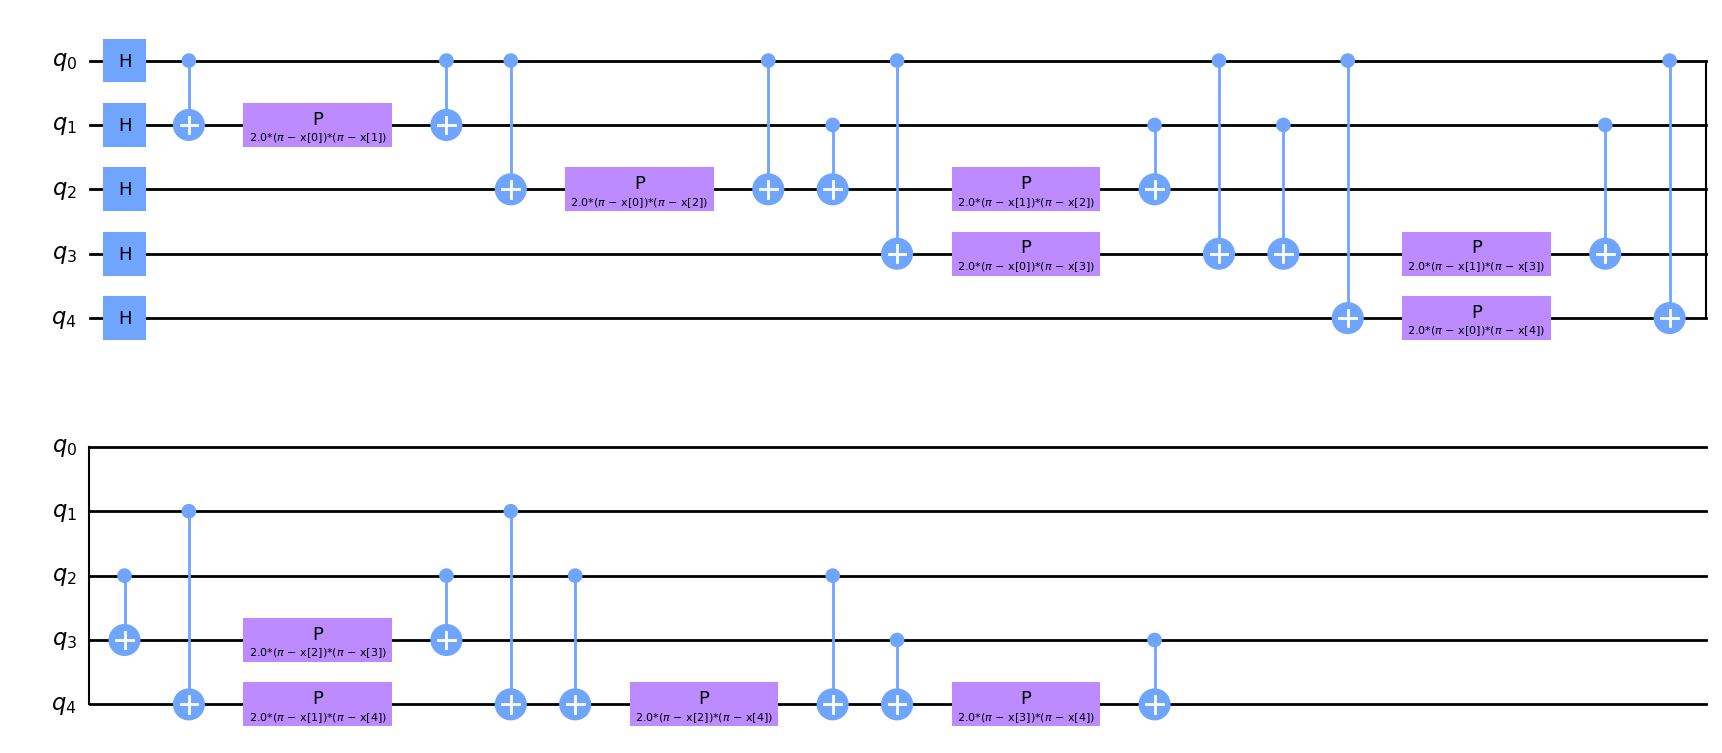

In [49]:
from qiskit.circuit.library import PauliFeatureMap

qc = PauliFeatureMap(feature_dimension=5, reps=1, paulis=["ZZ"], entanglement="full")

qc.decompose().draw(output="mpl")